In [ ]:
gates_count = 7
population_count = 1000
elitism_count = 100
mutation_count = 30
epoch = 1000
num_inputs = 4  # Set the number of inputs here

In [ ]:
gates_dictionary = {
    1: 'and',
    2: 'or',
    3: 'nand',
    4: 'nor',
    7: 'not',
    5: 'xor',
    6: 'xnor'
}

def logic_gate(a, b, gate):
    a = bool(a)
    b = bool(b)

    if gate.lower() == "and":
        return a and b
    elif gate.lower() == "or":
        return a or b
    elif gate.lower() == "nand":
        return not (a and b)
    elif gate.lower() == "nor":
        return not (a or b)
    elif gate.lower() == "buffer":
        return a
    elif gate.lower() == "not":
        return not a
    elif gate.lower() == "xor":
        return a != b
    elif gate.lower() == "xnor":
        return a == b



In [ ]:
import numpy as np
import pandas as pd
import itertools

def generate_truth_table(num_inputs, output_logic=None):
    # Generate all possible input combinations
    input_columns = [f"Input{i+1}" for i in range(num_inputs)]
    combinations = list(itertools.product([0, 1], repeat=num_inputs))

    # Initialize DataFrame
    truth_table = pd.DataFrame(combinations, columns=input_columns)

    # Generate Output column based on custom logic
    if output_logic:
        truth_table['Output'] = truth_table.apply(output_logic, axis=1)
    else:
        truth_table['Output'] = 0

    return truth_table


#output_logic = lambda row: 1 if int("".join(map(str, row.values.astype(int))), 2) > 6 else 0
output_logic = lambda row: row.sum() % 2
truth_table = generate_truth_table(num_inputs, output_logic)
#truth_table.to_csv('../files/truth_table.csv', index=False)
print(f"Truth table with {num_inputs} inputs saved to 'files/truth_table.csv'")
truth_table


Truth table with 4 inputs saved to 'files/truth_table.csv'


,Input1,Input2,Input3,Input4,Output
0,0,0,0,0,0
1,0,0,0,1,1
2,0,0,1,0,1
3,0,0,1,1,0
4,0,1,0,0,1
5,0,1,0,1,0
6,0,1,1,0,0
7,0,1,1,1,1
8,1,0,0,0,1
9,1,0,0,1,0


In [ ]:
import numpy as np
import random

population = np.zeros((population_count, num_inputs, num_inputs, 4))

def fill_random_population():
    global population
    global population_count
    global gates_count
    for i in range(population_count):
        for j in range(num_inputs):
            for k in range(num_inputs):
                input1 = random.randint(0, j*num_inputs+num_inputs-1)
                input2 = random.randint(0, j*num_inputs+num_inputs-1)
                gate = random.randint(1, gates_count)
                output = gate
                population[i][j][k] = [input1, input2, gate, output]


In [ ]:
def fitness(population):
    fitness_scores = []  
    for chromosome in range(population_count):
        correct = 0
        for eta, inputs in truth_table.iterrows():  # Iterate through rows using iterrows
            
            input_values = [inputs[f"Input{i+1}"] for i in range(num_inputs)]
            for row in range(num_inputs):
                for gen in range(num_inputs):
                    # Access input values using integer indices
                    try:
                        a_index = int(population[chromosome][row][gen][0])
                        b_index = int(population[chromosome][row][gen][1])

                        # Handle indices out of range
                        a = input_values[a_index] if 0 <= a_index < len(input_values) else population[chromosome][a_index // num_inputs - 1][a_index % num_inputs][3] if a_index > num_inputs-1 else 0
                        b = input_values[b_index] if 0 <= b_index < len(input_values) else population[chromosome][b_index // num_inputs - 1][b_index % num_inputs][3] if b_index > num_inputs-1 else 0

                    except IndexError:
                        print("IndexError: Index out of range")
                        continue

                    gate = int(population[chromosome][row][gen][2])
                    output = logic_gate(a, b, gates_dictionary[gate])

                    population[chromosome][row][gen][3] = output

            if population[chromosome][row][num_inputs - 1][3] == truth_table.loc[eta, 'Output']:
                correct += 1
        fitness_scores.append(correct)  # Append correct count to fitness_scores
        if correct == 2**num_inputs :
            print(population[chromosome])
    return population, fitness_scores  # Return the updated population


In [ ]:
import numpy as np

def elitism(population, fitness_scores):

    array_np = np.array(fitness_scores)
    temp = -1 * elitism_count
    top_10_indices = np.argsort(array_np)[temp:]

    elitism_arr = population[top_10_indices]
    return elitism_arr


def selection(population, fitness_scores):
    new_population = []
    for i in range(population_count - elitism_count):
        j = random.randint(0, population_count-1)
        if j == i:
            j +=1
        if fitness_scores[i] > fitness_scores[j]:
            new_population.append(population[i])
        else:
            new_population.append(population[j])

    return np.array(new_population)


def cross_over(population):

    for i in range(population_count - elitism_count-1):
        j = random.randint(0, population_count - elitism_count-1)
        if j == i:
            j +=1
        rand1 = random.randint(0, num_inputs - 1) # calls row
        rand2 = random.randint(0, num_inputs - 1) # calls gate 1
        rand3 = random.randint(0, num_inputs - 1) # calls gate 2

        temp = population[i][rand1][rand2][0]
        population[i][rand1][rand2][0] = population[j][rand1][rand3][0]
        population[j][rand1][rand3][0] = temp

        temp = population[i][rand1][rand2][1]
        population[i][rand1][rand2][1] = population[j][rand1][rand3][1]
        population[j][rand1][rand3][1] = temp
    return population

def mutation(population):

    for i in range(mutation_count):
        rand1 = random.randint(0, population.shape[0]-1) # calls chromosome
        rand2 = random.randint(0, num_inputs - 1) # calls row
        rand3 = random.randint(0, num_inputs - 1) # calls gate

        #population[rand1][rand2][rand3][2] = gates_count - population[rand1][rand2][rand3][2]+1
        population[rand1][rand2][rand3][2] = random.randint(1, gates_count)
    return population


In [ ]:
best_scores = []
i = 0
while True:
    print(f"epoch{i}", end= ' ')
    if i == 0:
        fill_random_population()
    population, fitness_scores = fitness(population)
    elitism_arr = elitism(population, fitness_scores)
    population = selection(population, fitness_scores)
    population = cross_over(population)
    population = mutation(population)
    population = np.concatenate((population, elitism_arr))
    best_scores.append(max(fitness_scores))
    i += 1
    print('best score in this epoch: ', max(fitness_scores))
    if max(fitness_scores) == 2**num_inputs:
        break


epoch0 best score in this epoch:  12
epoch1 best score in this epoch:  12
epoch2 best score in this epoch:  14
epoch3 best score in this epoch:  14
epoch4 best score in this epoch:  14
epoch5 best score in this epoch:  14
epoch6 best score in this epoch:  14
epoch7 [[[ 3.  2.  1.  1.]
  [ 2.  0.  3.  0.]
  [ 1.  3.  5.  0.]
  [ 2.  3.  3.  0.]]

 [[ 3.  2.  3.  0.]
  [ 3.  2.  2.  1.]
  [ 0.  4.  6.  1.]
  [ 2.  2.  2.  1.]]

 [[ 0. 11.  6.  1.]
  [ 7.  7.  5.  0.]
  [10.  2.  4.  0.]
  [ 2.  4.  6.  1.]]

 [[11. 15.  4.  0.]
  [ 3. 13.  7.  0.]
  [ 0. 13.  1.  0.]
  [ 6. 12.  6.  0.]]]
best score in this epoch:  16


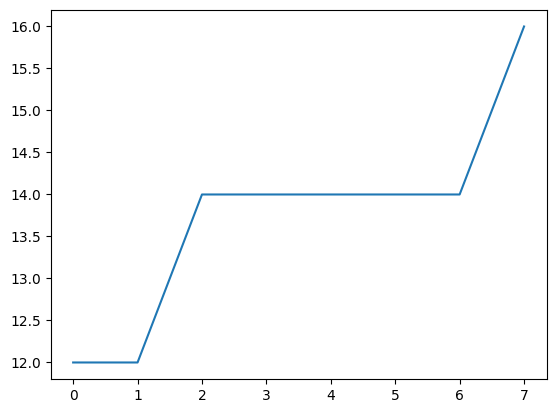

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.plot([i for i in range(len(best_scores))], best_scores)
plt.show()